### Importing required libraries

In [1]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV

### Utilities

In [40]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(
    axis='both',    
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off
   
    
    

### Importing data

In [54]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution 
The gF score is used to divide subjects in 2 or 3 classes.

[  5.   14.5]


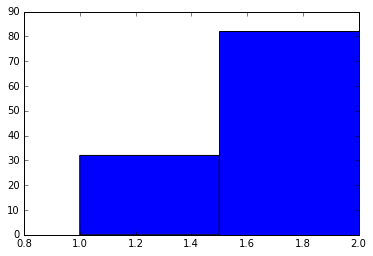

In [55]:
n_bins = 2

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
plt.hist(bins,n_bins)
print(bin_limits[:-1])

In [45]:
bins  = np.digitize(gF, [16, 20, 27])

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

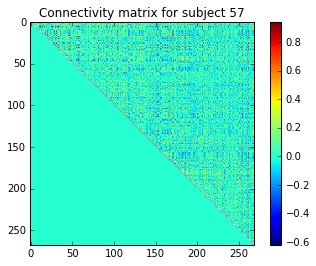

In [56]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj))    
    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Tests
Instead of performing regression in this experiment we try to divide subjects in 2 or 3 classes according to their gF score.

When performing PCA, select the number of components such that the amount of variance that needs to be explained is greater than 99.9%.

In [ ]:
# Test with all edges (PCA in CV)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
prob = np.zeros([n_subj,n_bins])
estimator = KNeighborsClassifier(n_neighbors=3)
pca = PCA(n_components=0.999)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[i] = estimator.predict(pca.transform(edges[test_index,]))
    prob[i,] = estimator.predict_proba(pca.transform(edges[test_index,]))
    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())
preds = predictions


In [58]:
print(prob)

[[ 0.66666667  0.33333333]
 [ 0.66666667  0.33333333]
 [ 0.          1.        ]
 [ 0.33333333  0.66666667]
 [ 0.          1.        ]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.          1.        ]
 [ 0.66666667  0.33333333]
 [ 0.66666667  0.33333333]
 [ 0.          1.        ]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.          1.        ]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]
 [ 0.          1.        ]
 [ 0.66666667  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.66666667  0.33333333]
 [ 0.66666667  0.33333333]
 [ 0.          1.        ]
 

In [16]:
confusion_matrix(bins, preds)

array([[10, 22],
       [27, 55]])

In [17]:
confusion_matrix(bins, preds_2)

array([[27, 25],
       [20, 42]])

In [20]:
confusion_matrix(bins, preds_3)

array([[ 1, 31],
       [ 6, 76]])

In [25]:
confusion_matrix(bins, preds_4)

array([[ 1, 31],
       [ 6, 76]])

[[ 0 17  3]
 [ 4 17 11]
 [ 5 32 25]]


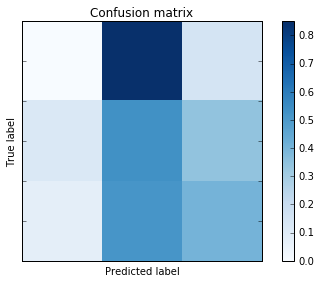

In [41]:
cm = confusion_matrix(bins, preds_5)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)

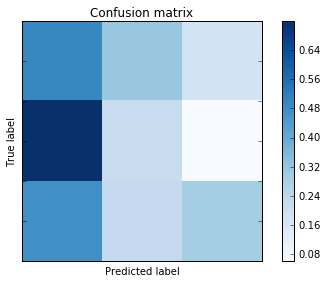

In [46]:
cm = confusion_matrix(bins, preds_6)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)

### Classification and regression
Data are split in training and test set. Then the training set is used to train a classifier in order to divide data in two classes according to their gF score. Two regressor are built, one for each of the classes, still using training data alone. Finally the trained classifier is used to assign each sample of the test data to one of the two regressors.

In [7]:
n_bins = 2
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])

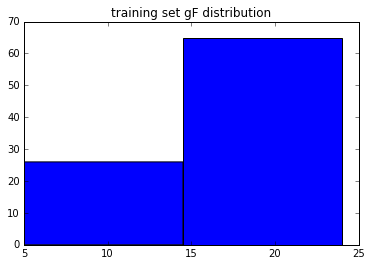

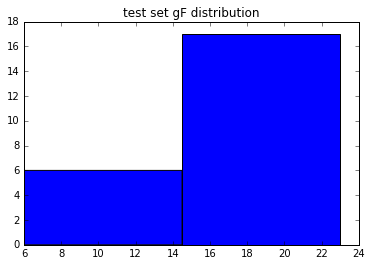

In [8]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
test_bins = np.digitize(y_test, bin_limits[:-1])
train_bins = np.digitize(y_train, bin_limits[:-1])

plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

In [17]:
errors_c = np.zeros([len(y_test)])
errors_r = np.zeros([len(y_test)])
predictions_c = np.zeros([len(y_test)])
predictions_r = np.zeros([len(y_test)])
estimator = KNeighborsClassifier(n_neighbors=5)
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 2

# decomposition
data_pc = pca.fit_transform(X_train)

# classification
estimator.fit(data_pc,train_bins)
predictions_c = estimator.predict(pca.transform(X_test))
errors_c = predictions_c==test_bins

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r[predictions_c==1] = lasso.predict(X_test[predictions_c==1])
errors_r[test_bins==1] = abs(predictions_r[test_bins==1]-y_test[test_bins==1])

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r[predictions_c==2] = lasso.predict(X_test[predictions_c==2])      
errors_r[test_bins==2] = abs(predictions_r[test_bins==2]-y_test[test_bins==2])



In [18]:
print(confusion_matrix(test_bins, predictions_c))
print('Mean regression error:',errors_r.mean())

[[ 1  5]
 [ 3 14]]
Mean regression error: 4.49255144975


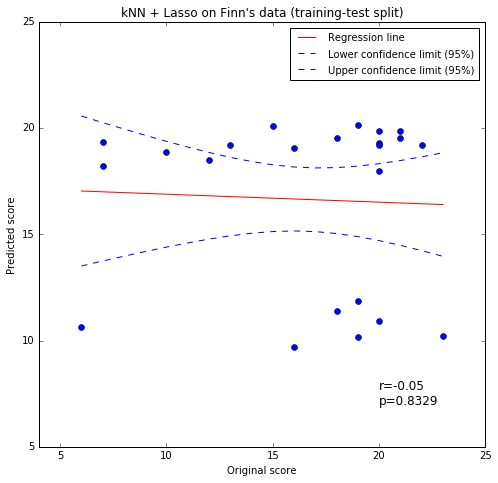

In [14]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'kNN + Lasso on Finn\'s data (training-test split)')

### Classification and regression with leave-one-out cross-validation

In [70]:
loo = cross_validation.LeaveOneOut(n_subj)
errors_c = np.zeros([n_subj])
errors_r = np.zeros([n_subj])
predictions_c = np.zeros([n_subj])
predictions_r = np.zeros([n_subj])
estimator = KNeighborsClassifier(n_neighbors=3)
pca = PCA(n_components=0.999)
k=5
n_bins = 2
n_bins_cv = 4
cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    X_train, X_test, y_train, y_test = edges[train_index,], edges[test_index,],gF[train_index],gF[test_index]
    hist, bin_limits = np.histogram(y_train, n_bins)
    bins = np.digitize(y_train, bin_limits[:-1])
    test_bin = np.digitize(y_test, bin_limits[:-1])
    # decomposition
    data_pc = pca.fit_transform(X_train)
    # classification
    estimator.fit(data_pc,bins)
    predictions_c[i] = estimator.predict(pca.transform(X_test))
    errors_c[i] = 1 if predictions_c[i]==test_bin else 0
    
    #hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
    #bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
    #cv = cross_validation.StratifiedKFold(bins_cv,k)
    
    if predictions_c[i] == 1:
        # regression 1
        lasso.fit(X_train[bins==1,],y_train[bins==1])
        predictions_r[i] = lasso.predict(X_test)
        errors_r[i] = abs(predictions_r[i]-y_test)
    else:
        # regression 2
        lasso.fit(X_train[bins==2,],y_train[bins==2])
        predictions_r[i] = lasso.predict(X_test)
        errors_r[i] = abs(predictions_r[i]-y_test)
    
    i += 1
    f.value += 1
        
print('Accuracy:',errors_c.mean())
print('Mean error:',errors_r.mean())


Accuracy: 0.570175438596
Mean error: 4.86379378542


In [71]:
print(predictions_r)
print(gF)
print(predictions_c)

[ 10.34375     10.34375     19.44828835  19.33314359  19.37037037  10.34375
  19.38271605  10.50534548  19.27160494  10.35483871  19.33333333
  19.32926829  10.34375     10.41935484  19.34567901  19.32926829
  19.32926829  19.27160494  10.34375     19.32926829  10.34375     19.32098765
  19.33333333  19.32098765  19.33333333  19.32926829  19.30864198
  19.35802469  19.33333333  19.34567901  19.28395062  19.32098765  10.34375
  19.32926829  10.34375     10.34375     19.2962963   19.35802469
  19.38271605  10.34375     19.32926829  19.30864198  10.34375     10.48387097
  19.34567901  19.2962963   10.34375     19.32926829  19.28395062
  19.35802469  19.32926829  10.34375     19.32926829  10.34375     10.34375
  19.32926829  19.30864198  10.34375     10.34375     10.34375     19.38271605
  19.32926829  19.2962963   10.34375     19.38271605  19.35802469
  19.32926829  10.29032258  19.34567901  19.34567901  19.30864198  10.34375
  19.32098765  19.30864198  10.34375     19.32098765  19.320987

In [72]:
n_bins = 2
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
confusion_matrix(bins, predictions_c)

array([[10, 22],
       [27, 55]])

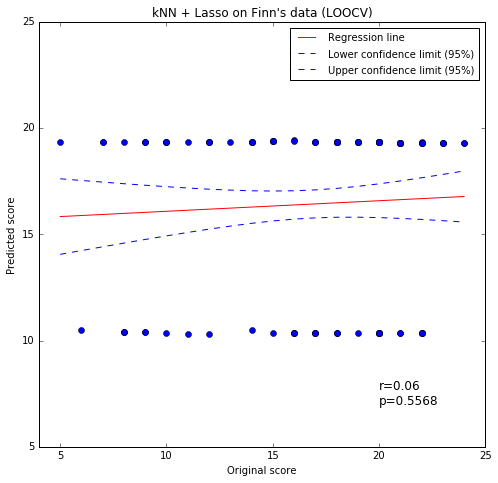

In [73]:
regression_plot(np.ravel(gF),predictions_r,n_subj,'kNN + Lasso on Finn\'s data (LOOCV)')

#### Preliminary test
In order to evaluate the performance of the double regression, an oracle is used instead of the classifier

In [18]:
loo = cross_validation.LeaveOneOut(n_subj)
errors_r = np.zeros([n_subj])
predictions_r = np.zeros([n_subj])
k=5
n_bins = 2
n_bins_cv = 4
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    X_train, X_test, y_train, y_test = edges[train_index,], edges[test_index,],gF[train_index],gF[test_index]
    hist, bin_limits = np.histogram(y_train, n_bins)
    bins = np.digitize(y_train, bin_limits[:-1])
    test_bin = np.digitize(y_test, bin_limits[:-1])
    
    if test_bin == 1:
        # regression 1
        hist_cv, bin_limits_cv = np.histogram(y_train[bins==1], n_bins_cv)
        bins_cv = np.digitize(y_train[bins==1], bin_limits_cv[:-1])
        cv = cross_validation.StratifiedKFold(bins_cv,k)
        lasso = LassoCV(cv=cv,n_jobs=-1)
        lasso.fit(X_train[bins==1,],y_train[bins==1])
        predictions_r[i] = lasso.predict(X_test)
        errors_r[i] = abs(predictions_r[i]-y_test)
    else:
        # regression 2
        hist_cv, bin_limits_cv = np.histogram(y_train[bins==2], n_bins_cv)
        bins_cv = np.digitize(y_train[bins==2], bin_limits_cv[:-1])
        cv = cross_validation.StratifiedKFold(bins_cv,k)
        lasso = LassoCV(cv=cv,n_jobs=-1)
        lasso.fit(X_train[bins==2,],y_train[bins==2])
        predictions_r[i] = lasso.predict(X_test)
        errors_r[i] = abs(predictions_r[i]-y_test)
    
    i += 1
    f.value += 1
        
print('Mean error:',errors_r.mean())
print(predictions_r)

C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any

Mean error: 2.20228445536
[ 19.35802469  19.34073025  19.37037037  19.05160996  20.185034
  19.46434959  19.87369982  10.46930599  18.47846992  10.788681
  20.04710193  12.40553655  19.14692991   9.8031376   19.72838298
  10.59637619  10.96605715  19.27160494  19.33828947  11.83121645
  19.37547246  19.24169419  19.40956326  18.98626788  19.63024393
   9.93510863  19.30864198  19.27333041  18.95972824  19.73517884
  18.44960385  19.32131908  19.86161012  10.01737541  19.31469092
  19.2962963   19.2962963   19.31442135  19.38271605  19.21926654
   6.75225107  19.03761832  19.31027949  10.26238886  19.27262001
  19.73354552  18.96405949  10.52477733  19.19413023  19.35659439
  19.0204032   19.46055559  11.49946395  19.2916394   19.38271605
  10.94787848  19.2295488   19.61293719  19.41976967  19.32327149
  19.17561617   9.74724413  19.16348881  18.99125566  19.38271605
  19.47805314  10.038874    11.04982865  19.27744569  18.52555361
  19.28670117  19.41053818  18.50330379  19.25767342  

preds = [ 18.19233306  17.91531932  19.44828835  19.33314359  19.37037037
  19.35802469  19.38271605  10.50534548  19.27160494  10.35483871
  19.33333333  10.29032258  19.2962963   10.41935484  19.34567901
  10.41935484  10.22580645  19.27160494  19.32098765  10.25806452
  19.32098765  19.32098765  19.33333333  19.32098765  19.33333333
  10.35483871  19.30864198  19.35802469  19.33333333  19.34567901
  19.28395062  19.32098765  19.34567901  10.32258065  19.2962963
  19.2962963   19.2962963   19.35802469  19.38271605  19.30864198
  10.35483871  19.30864198  19.35802469  10.48387097  19.34567901
  19.2962963   19.2962963   10.38709677  19.28395062  19.35802469
  19.32926829  19.37037037  10.38709677  19.32098765  19.38271605
  10.29032258  19.30864198  19.32098765  19.37037037  19.37037037
  19.38271605  10.38709677  19.2962963   19.34567901  19.38271605
  19.35802469  10.22580645  10.29032258  19.34567901  19.34567901
  19.30864198  19.2962963   19.32098765  19.30864198  19.34567901
  19.32098765  19.32098765  10.29032258  19.28395062  10.4516129
  10.32258065  10.22580645  10.38709677  19.30864198  19.32098765
  10.41935484  19.32098765  19.32098765  19.2962963   19.28395062
  10.29032258  19.30864198  10.38709677  19.34567901  19.32098765
  19.37037037  19.30864198  10.35483871  10.41935484  19.33333333
  10.4516129   19.32098765  19.30864198  19.32098765  19.38271605
  10.35483871  19.34567901  10.22580645  19.32098765  19.34567901
  19.33333333  19.33333333  19.2962963   10.22580645]

In [15]:
print(X_test.shape)
print(i)

(1, 35778)
114


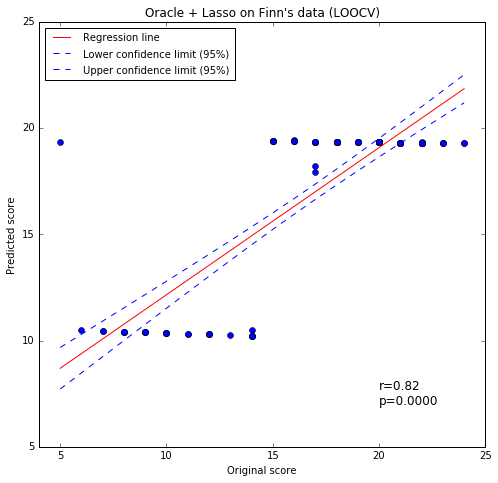

In [8]:
regression_plot(np.ravel(gF),predictions_r,n_subj,'Oracle + Lasso on Finn\'s data (LOOCV)')

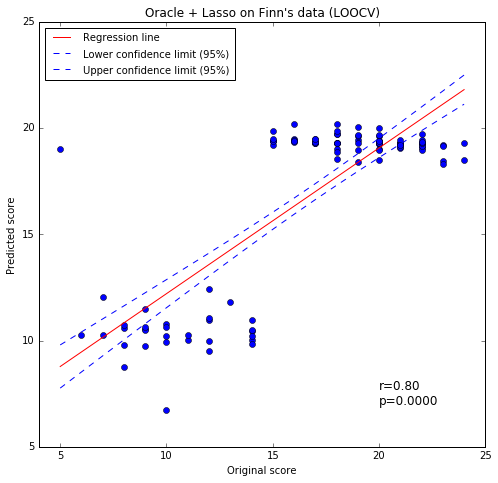

In [19]:
regression_plot(np.ravel(gF),predictions_r,n_subj,'Oracle + Lasso on Finn\'s data (LOOCV)')